In [11]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

base = '/content/COVID-19_Radiography_Dataset/'

In [15]:
folders = os.listdir(base)
print(folders)

['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']


In [16]:
%%time

Data, Lables = [], []

for item in folders:
  new_path = os.path.join(base, item)
  new_path += '/images'
  for img in os.listdir(new_path):
    img_path = os.path.join(new_path, img)
    Data.append(np.array(cv2.resize(cv2.imread(img_path).astype('float32'), (72,72))))
    Lables.append(folders.index(item))

CPU times: user 56 s, sys: 11.7 s, total: 1min 7s
Wall time: 41.8 s


In [17]:
Data = np.array(Data)
Lables = np.array(Lables)
print('Data Shape', Data.shape)
print('Lable Shape', Lables.shape)

Data Shape (21165, 72, 72, 3)
Lable Shape (21165,)


In [18]:
x_train, x_test, y_train, y_test = train_test_split(Data, Lables, test_size = .2, random_state = 1)

In [19]:
print('x_train Shape', x_train.shape)
print('x_test Shape', x_test.shape)
print('y_train Shape', y_train.shape)
print('y_test Shape', y_test.shape)

x_train Shape (16932, 72, 72, 3)
x_test Shape (4233, 72, 72, 3)
y_train Shape (16932,)
y_test Shape (4233,)


In [20]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = Data[0].shape[0]  
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [21]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [23]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [24]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
def create_vit_classifier():
    inputs = keras.layers.Input(shape = Data[0].shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = keras.layers.Dense(len(folders))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [29]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
60/60 [==============================] - 34s 419ms/step - loss: 1.5022 - accuracy: 0.5725 - val_loss: 0.7198 - val_accuracy: 0.7084
Epoch 2/100
60/60 [==============================] - 24s 400ms/step - loss: 0.8257 - accuracy: 0.6587 - val_loss: 0.7420 - val_accuracy: 0.7125
Epoch 3/100
60/60 [==============================] - 24s 400ms/step - loss: 0.7448 - accuracy: 0.6968 - val_loss: 0.6318 - val_accuracy: 0.7769
Epoch 4/100
60/60 [==============================] - 23s 382ms/step - loss: 0.6954 - accuracy: 0.7222 - val_loss: 0.5763 - val_accuracy: 0.7698
Epoch 5/100
60/60 [==============================] - 23s 384ms/step - loss: 0.6541 - accuracy: 0.7394 - val_loss: 0.5574 - val_accuracy: 0.7739
Epoch 6/100
60/60 [==============================] - 24s 399ms/step - loss: 0.6207 - accuracy: 0.7586 - val_loss: 0.5181 - val_accuracy: 0.7999
Epoch 7/100
60/60 [==============================] - 24s 398ms/step - loss: 0.5873 - accuracy: 0.7716 - val_loss: 0.5055 - val_accuracy:

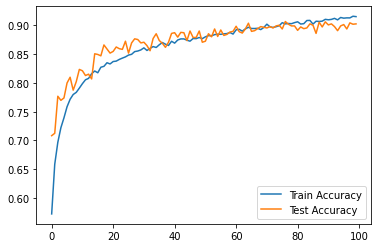

In [30]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.legend()
plt.show()

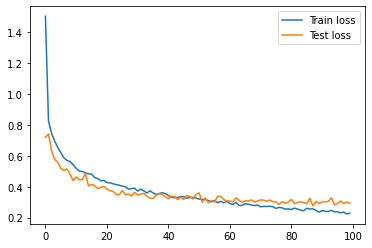

In [31]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()
plt.show()